In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import sqlite3
import pandas as pd

In [2]:
def flatLC(t,t0, t1, peak=10):
    # Make an array of magnitudes to match input times
    lightcurve = np.zeros(np.size(t), dtype=float) + 99.
    # Select only times in the lightcurve duration window
    good = np.where( (t >= t0) & (t <= t1) )
    lightcurve[good] = peak
    return lightcurve

In [3]:
class SingleDetectMetric(metrics.BaseMetric):
    """
    Quantifies detectability of toyObjects.
    
    Parameters
    ----------
    ptsNeeded : int
        Number of an object's lightcurve points required to be above the 5-sigma limiting depth 
        before it is considered detected.
    
    Notes
    -----
    This metric assumes this will be run with a slicer that has had extra 
    parameters (t0, durration) added to the slicer.slicePoint 
    dict (which already contains ra, dec, fieldID, etc). All the observation information 
    (MJD of observation, 5-sigma limiting depth of each observation, etc) is contained in the
    dataSlice array. We request the filter information for each observation anticipating that
    more general lightcurve functions will need it as input.
    """
    def __init__(self, metricName='DetectabilityMetric', mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', ptsNeeded=1, total_obs=False, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.ptsNeeded = ptsNeeded
        self.total_obs = total_obs
        super(SingleDetectMetric, self).__init__(col=[self.mjdCol, self.m5Col, 
                                                          self.filterCol],
                                                     units='Detected, 0 or 1',
                                                     metricName=metricName,
                                                     **kwargs)
        
    def run(self,  dataSlice, slicePoint=None):
        # Generate the lightcurve for this object
        lightcurve = flatLC(dataSlice[self.mjdCol], slicePoint['t0'],  slicePoint['t1'])
        # Check if there are enough points detected in the generated lightcurve
        npts = np.where( (lightcurve != 0.) & (lightcurve < dataSlice[self.m5Col]))[0].size
        if self.total_obs:
            return npts
        if npts >= self.ptsNeeded:
            return 1
        else:
            return 0

In [4]:
dbs = ['too_pairsmix_rate1_10yrs.db', 'too_pairsmix_rate10_10yrs.db', 
       'too_pairsmix_rate50_10yrs.db','too_pairsmix_rate100_10yrs.db']


Querying database SummaryAllProps with no constraint for columns ['rotSkyPos', 'fiveSigmaDepth', 'filter', 'observationStartMJD', 'fieldDec', 'fieldRA'].
Found 2609403 visits
Running:  ['too_pairsmix_rate1_cameraOff_USER', 'too_pairsmix_rate1_total_obs_cameraOff_USER']
Completed metric generation.
Running:  ['too_pairsmix_rate1_cameraOn_USER', 'too_pairsmix_rate1_total_obs_cameraOn_USER']


/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/_erfa/core.py:118: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "' + func_name + '" yielded ' + wmsg, ErfaWarning)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
-------No Camera---------
Number of events 10
2 out of footprint
6 detected
2 not detected
42.0 Total number of event observations
-------Chip Gaps On---------
Number of events 10
2 out of footprint
6 detected
2 not detected
39.0 Total number of event observations


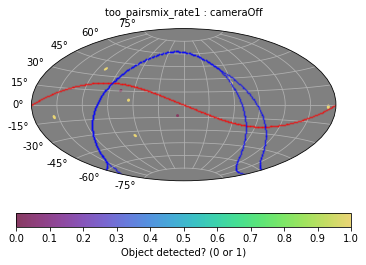

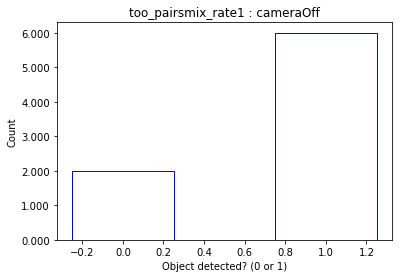

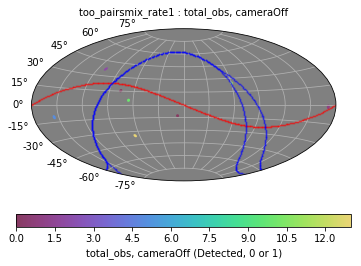

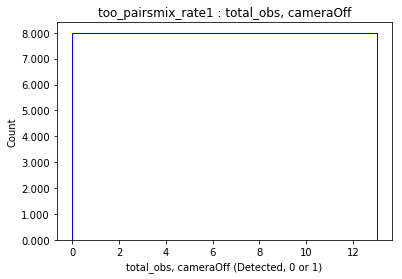

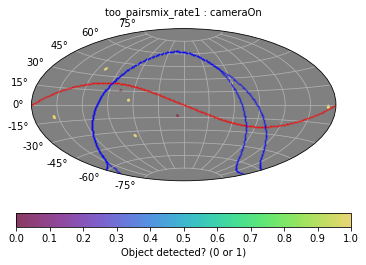

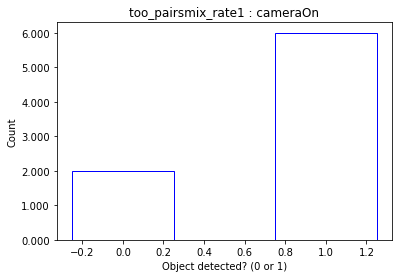

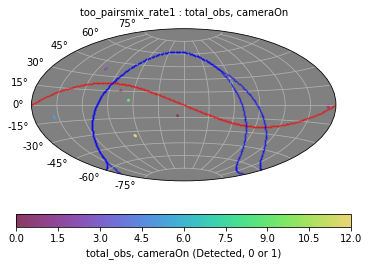

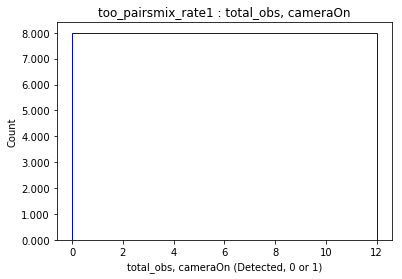

In [7]:
# Pull the events out
for dbindx in [0]: #np.arange(len(dbs)):

    con = sqlite3.connect(dbs[dbindx])
    events = pd.read_sql('select * from events;', con)
    con.close()
    
    slicer = slicers.UserPointsSlicer(np.degrees(events['ra']), np.degrees(events['dec']), latLonDeg=True)
    slicer.slicePoints['t0'] = events['mjd_start']
    slicer.slicePoints['t1'] = events['expires']
    
    database = db.OpsimDatabase(dbs[dbindx])
    outDir = 'temp'
    resultsDb = db.ResultsDb(outDir=outDir)
    runName= dbs[dbindx][:-9]

    metric = SingleDetectMetric(metricName='cameraOff')
    sql = ''
    plotDict = {'xlabel':'Object detected? (0 or 1)'}
    plotDict['bins'] = [-0.25, 0.25, 0.75, 1.25]
    bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName, plotDict=plotDict)
    bundleList = [bundle]
    metric = SingleDetectMetric(metricName='total_obs, cameraOff', total_obs=True)
    bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
    bundleList.append(bundle)
    
    # Let's do it with the camera on as well
    metric = SingleDetectMetric(metricName='cameraOn')
    slicer = slicers.UserPointsSlicer(np.degrees(events['ra']), np.degrees(events['dec']), latLonDeg=True, useCamera=True)
    slicer.slicePoints['t0'] = events['mjd_start']
    slicer.slicePoints['t1'] = events['expires']
    bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName, plotDict=plotDict)
    bundleList.append(bundle)
    metric = SingleDetectMetric(metricName='total_obs, cameraOn', total_obs=True)
    bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)
    bundleList.append(bundle)
    
    for b in bundleList:
        b.setRunName(runName)
    
    bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
    bgroup = metricBundles.MetricBundleGroup(bundleDict, database, outDir=outDir, resultsDb=resultsDb)
    
    bgroup.runAll()

    bgroup.plotAll(closefigs=False)
    
    print('-------No Camera---------')
    print('Number of events', len(events))
    print(np.where(bundleList[0].metricValues.mask == True)[0].size, 'out of footprint')
    print(np.where(bundleList[0].metricValues == 1)[0].size, 'detected')
    print(np.where(bundleList[0].metricValues == 0)[0].size, 'not detected')
    print(np.median(bundleList[1].metricValues.sum()), 'Total number of event observations')

    print('-------Chip Gaps On---------')
    print('Number of events', len(events))
    print(np.where(bundleList[2].metricValues.mask == True)[0].size, 'out of footprint')
    print(np.where(bundleList[2].metricValues == 1)[0].size, 'detected')
    print(np.where(bundleList[2].metricValues == 0)[0].size, 'not detected')
    print(np.median(bundleList[3].metricValues.sum()), 'Total number of event observations')
